In [1]:
import numpy as np

#measuring units for length is m
#define the size of the domain
L = 10;
H = 2

del_l = 0.1; #size of CV side

#number of cells in each direction
N_x = int(L/del_l);
N_y = int(H/del_l);

print(N_x, N_y)

100 20


In [2]:
#define the arrays for the scalar CV
#define arrays for storing velocities in a forward staggered arrangement

scalar_CV = np.zeros((1, N_x*N_y));
vel_u = np.zeros((1, (N_x + 1)*N_y));
vel_v = np.zeros((1, N_x*(N_y + 1))); #needed for completeness

In [3]:
#define the velocity field

#v_velocity field is 0

#u velocity field is a linear field from u_0 - first cell- to 0 - last cell -

u_0 = 0;
profile_u_1D = np.linspace(u_0, 0, (N_x +1));

for i in range(0, N_x):
    a = i*N_y;
    b = a + N_y;
    vel_u[0, a:b] = profile_u_1D[i];

print(profile_u_1D)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


In [4]:
#computation of the fows

rho = 1; #g/cm^3
heat_c = 4.182; #J/gK at 25 deg C
A = del_l**2;

#u-flow
F_u = vel_u*rho*heat_c;
#v-flow
F_v = vel_v*rho*heat_c; #for completeness

#thermal condutivity of water
kappa = 0.589; #W/mK at 20 deg C
#NB the conductivity is subject to variation with temperature

#diffusive thermal conductance
D = (kappa/del_l);

print(D)
print(F_u)
print(F_v)

5.89
[[0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]]


In [5]:
#implementation of BC

#inlet and outlet BC for scalar CV 
#the velocity field is alrady given
#ignore pressure variations
mat_1 = np.zeros((1, N_y));
mat_2 = np.zeros((1, N_y));

#inlet temperature
mat_1[0, :] = 303;
inlet_BC = mat_1;
#outlet temperature
mat_2[0, :] = 273;
outlet_BC = mat_2;

#wall BC, constant heat flux out of the domain (J/s)
heat_F_b = 0/A;
heat_F_t = 0/A; #careful with the signs
#these variables will be needed to deal with the source terms

print(inlet_BC)
print(outlet_BC)

[[303. 303. 303. 303. 303. 303. 303. 303. 303. 303. 303. 303. 303. 303.
  303. 303. 303. 303. 303. 303.]]
[[273. 273. 273. 273. 273. 273. 273. 273. 273. 273. 273. 273. 273. 273.
  273. 273. 273. 273. 273. 273.]]


In [6]:
#DOMAIN CREATION
#matrix construction, we are going to use the formalism of a sparsely occupied matrix
#we use CD for boundary cells
#we use HYBRID scheme for interior cells

#sparsely occupied matrix
#each row of the the hiantic matrix contains at most five elements 
#so we can in genreal arrange the sparsely occupied fomalism in the following way:
#first column goes the row, from 1 to N_y*N_x (all cells)
#second column goes the column in the matrix, from 1 to 5
#third column goes the coeffcient

#we use if-clauses to contruct the geometry
#next time you can also try the "in" command

sol_mat = np.zeros((N_x*N_y*5, 3));

inlet_cells = np.linspace(0, N_y - 1, N_y);
outlet_cells = np.linspace((N_x -1)*N_y, N_x*N_y -1, N_y);
bottom_wall_cells = (np.linspace(0,(N_x -1)*N_y, N_x ));
top_wall_cells = (np.linspace(N_y - 1, N_x*N_y - 1, N_x ));

for N in range(0, N_x*N_y):
    a = N*5;
    b = a + 5;
    sol_mat[a:b, 0] = N; #already the counting system in py

#define all cells
for M in range(0, N_x*N_y):
    a = M*5;
    
    sol_mat[a, 1] = M - 1; #south
    sol_mat[a + 1, 1] = M - N_y; #west
    sol_mat[a + 2, 1] = M; #P
    sol_mat[a + 3, 1] = M + N_y; #east
    sol_mat[a + 4, 1] = M + 1; #north

#adjust walls
for M in range(0, N_x*N_y):
    a = M*5;  
    
    for t in range(0, N_x):
        if M == bottom_wall_cells[t]:
            sol_mat[a, 1] = 0; #south
            sol_mat[a + 1, 1] = M - N_y; #west
            sol_mat[a + 2, 1] = M; #P
            sol_mat[a + 3, 1] = M + N_y; #east
            sol_mat[a + 4, 1] = M + 1; #north
        elif M == top_wall_cells[t]:
            sol_mat[a, 1] = M - 1; #south
            sol_mat[a + 1, 1] = M - N_y; #west
            sol_mat[a + 2, 1] = M; #P
            sol_mat[a + 3, 1] = M + N_y; #east
            sol_mat[a + 4, 1] = 0; #north

#adjust inlet and outlet
for M in range(0, N_x*N_y):
    a = M*5;
    
    for p in range(0, N_y):
        if M == inlet_cells[p]:
            sol_mat[a, 1] = M - 1; #south
            sol_mat[a + 1, 1] = 0; #west
            sol_mat[a + 2, 1] = M; #P
            sol_mat[a + 3, 1] = M + N_y; #east
            sol_mat[a + 4, 1] = M + 1; #north
        elif M == outlet_cells[p]:
            sol_mat[a, 1] = M - 1; #south
            sol_mat[a + 1, 1] = M - N_y; #west
            sol_mat[a + 2, 1] = M; #P
            sol_mat[a + 3, 1] = 0; #east
            sol_mat[a + 4, 1] = M + 1; #north

#adjust corners
for M in range(0, N_x*N_y):
    a = M*5;
    
    if M == 0:
        sol_mat[a, 1] = 0; #south
        sol_mat[a + 1, 1] = 0; #west
        sol_mat[a + 2, 1] = M; #P
        sol_mat[a + 3, 1] = M + N_y; #east
        sol_mat[a + 4, 1] = M + 1; #north
    elif M == (N_y - 1):
        sol_mat[a, 1] = M - 1; #south
        sol_mat[a + 1, 1] = 0; #west
        sol_mat[a + 2, 1] = M; #P
        sol_mat[a + 3, 1] = M + N_y; #east
        sol_mat[a + 4, 1] = 0; #north
    elif M == (N_x - 1)*N_y:
        sol_mat[a, 1] = 0; #south
        sol_mat[a + 1, 1] = M - N_y; #west
        sol_mat[a + 2, 1] = M; #P
        sol_mat[a + 3, 1] = 0; #east
        sol_mat[a + 4, 1] = M + 1; #north
    elif M == N_x*N_y -1:
        sol_mat[a, 1] = M - 1; #south
        sol_mat[a + 1, 1] = M - N_y; #west
        sol_mat[a + 2, 1] = M; #P
        sol_mat[a + 3, 1] = 0; #east
        sol_mat[a + 4, 1] = 0; #north
        

In [7]:
#calculation of the coeffcients and input in solution matrix (sol_mat)

#start from cells 0 and 1

#cell 0, apply CD
sol_mat[2, 2] = 3*D + (F_u[0, N_y] - F_u[0, 0] + F_v[0, 1])/2;
sol_mat[3, 2] = F_u[0, N_y]/2 - D;
sol_mat[4, 2] = F_v[0, 1]/2 - D;

#cell 1, apply CD
sol_mat[5, 2] = -F_v[0, 1]/2 - D;
sol_mat[7, 2] = 4*D + (F_u[0, 1 + N_y] - F_u[0, 1] + F_v[0, 2] - F_v[0, 1])/2;
sol_mat[8, 2] = F_u[0, 1 + N_y]/2 - D;
sol_mat[9, 2] = F_v[0, 2]/2 - D;

In [8]:
#HYBRID SCHEME IMPLEMENTATION
#loop for the calculation of all the other coefficients
#NB: even though we don't have these terms we DO HAVE their fluxes thanks to the staggered arrangement
#the computation process is expained on the paper notes

B_cells = np.r_[inlet_cells, bottom_wall_cells, top_wall_cells, outlet_cells]; #list of all B cells

for t in range(2, N_x*N_y):
    #define enumerators for the cells
    S = t*5;
    W = S + 1;
    P = W + 1;
    E = P + 1;
    N = E + 1;
    
    #code has been corrected to make sure that it applies the boundaries correctly
    #the same basic structure has been kept, after I designed the data structure to be solid
    #############################################################################
    if (t in B_cells) == True: 
        w = sol_mat[S : (S+5), 1];
        mask = np.ones((1, 5));
        mask[0, w == 0] = 0;
        
        a_S = (-F_v[0, t]/2 - D);
        a_W = (-F_u[0, t]/2 - D);
        a_E = (F_u[0, t + N_y]/2 - D);
        a_N = (F_v[0, t + 1]/2 - D);
        a_P = (F_u[0, t + N_y] - F_u[0, t] + mask[0, 4]*F_v[0, t + 1] - mask[0, 0]*F_v[0, t] - a_E - mask[0, 4]*a_N - a_W - mask[0, 0]*a_S );
        
        sol_mat[S, 2] = mask[0, 0]*a_S;
        sol_mat[W, 2] = mask[0, 1]*a_W;
        sol_mat[P, 2] = a_P;
        sol_mat[E, 2] =  mask[0, 3]*a_E;
        sol_mat[N, 2] =  mask[0, 4]*a_N;
    #############################################################################

        #these lines of code below are completely general for all interior cells
    elif (t in B_cells) == False:
        Pe_u = abs((F_u[0, t]+F_u[0, t + N_y])/(2*D));
        Pe_v = abs((F_v[0, t]+F_v[0, t + 1])/(2*D));
        if Pe_u > 2 and Pe_v > 2: #full upwind
            if F_u[0, t] > 0 and F_u[0, t + N_y] > 0 and F_v[0, t] > 0 and F_v[0, t + 1] > 0:
                a_S = -F_v[0, t] - D;
                a_W = -F_u[0, t] - D;
                a_E = - D;
                a_N = - D;
                a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
                 
                sol_mat[S, 2] = a_S;
                sol_mat[W, 2] = a_W;
                sol_mat[P, 2] = a_P;
                sol_mat[E, 2] = a_E;
                sol_mat[N, 2] = a_N;
            elif F_u[0, t] > 0 and F_u[0, t + N_y] > 0 and F_v[0, t] < 0 and F_v[0, t + 1] < 0:
                a_S = - D;
                a_W = -F_u[0, t] - D;
                a_E = - D;
                a_N = F_v[0, t + 1] - D ;
                a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
                 
                sol_mat[S, 2] = a_S;
                sol_mat[W, 2] = a_W;
                sol_mat[P, 2] = a_P;
                sol_mat[E, 2] = a_E;
                sol_mat[N, 2] = a_N;
            elif F_u[0, t] < 0 and F_u[0, t + N_y] < 0 and F_v[0, t] > 0 and F_v[0, t + 1] > 0:
                a_S = -F_v[0, t] - D;
                a_W = - D;
                a_E = F_u[0, t + N_y] - D;
                a_N = - D ;
                a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
                 
                sol_mat[S, 2] = a_S;
                sol_mat[W, 2] = a_W;
                sol_mat[P, 2] = a_P;
                sol_mat[E, 2] = a_E;
                sol_mat[N, 2] = a_N;
            elif F_u[0, t] < 0 and F_u[0, t + N_y] < 0 and F_v[0, t] > 0 and F_v[0, t + 1] > 0:
                a_S = - D;
                a_W = - D;
                a_E = F_u[0, t + N_y] - D;
                a_N = F_v[0, t + 1] - D ;
                a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
                 
                sol_mat[S, 2] = a_S;
                sol_mat[W, 2] = a_W;
                sol_mat[P, 2] = a_P;
                sol_mat[E, 2] = a_E;
                sol_mat[N, 2] = a_N;
        elif Pe_u > 2 and Pe_v < 2: #upwind only in u-direction
            if F_u[0, t] > 0 and F_u[0, t + N_y] > 0:
                a_S = -F_v[0, t]/2 - D;
                a_W = -F_u[0, t] - D;
                a_E = - D;
                a_N = F_v[0, t + 1]/2 - D;
                a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
                 
                sol_mat[S, 2] = a_S;
                sol_mat[W, 2] = a_W;
                sol_mat[P, 2] = a_P;
                sol_mat[E, 2] = a_E;
                sol_mat[N, 2] = a_N;
            elif F_u[0, t] < 0 and F_u[0, t + N_y] < 0:
                a_S = -F_v[0, t]/2 - D;
                a_W = - D;
                a_E = F_u[0, t + N_y] - D;
                a_N = F_v[0, t + 1]/2 - D;
                a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
                 
                sol_mat[S, 2] = a_S;
                sol_mat[W, 2] = a_W;
                sol_mat[P, 2] = a_P;
                sol_mat[E, 2] = a_E;
                sol_mat[N, 2] = a_N;
        elif Pe_u < 2 and Pe_v > 2: #upwind only in v-direction
            if F_v[0, t] > 0 and F_v[0, t + 1] > 0:
                a_S = - F_v[0, t] - D;
                a_W = -F_u[0, t]/2 - D;
                a_E = F_u[0, t + N_y]/2 - D;
                a_N = - D;
                a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
                 
                sol_mat[S, 2] = a_S;
                sol_mat[W, 2] = a_W;
                sol_mat[P, 2] = a_P;
                sol_mat[E, 2] = a_E;
                sol_mat[N, 2] = a_N;
            elif F_v[0, t] < 0 and F_v[0, t + 1] < 0:
                a_S = - D;
                a_W = -F_u[0, t]/2 - D;
                a_E =  F_u[0, t + N_y]/2 - D;
                a_N = F_v[0, t + 1] - D;
                a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
                 
                sol_mat[S, 2] = a_S;
                sol_mat[W, 2] = a_W;
                sol_mat[P, 2] = a_P;
                sol_mat[E, 2] = a_E;
                sol_mat[N, 2] = a_N;
        elif Pe_u < 2 and Pe_v < 2: # full CD
            a_S = -F_v[0, t]/2 - D;
            a_W = -F_u[0, t]/2 - D;
            a_E = F_u[0, t + N_y]/2 - D;
            a_N = F_v[0, t + 1]/2 - D;
            a_P = (F_u[0, t + N_y] - F_u[0, t] + F_v[0, t + 1] - F_v[0, t] - a_E - a_N - a_W - a_S );
        
            sol_mat[S, 2] = a_S;
            sol_mat[W, 2] = a_W;
            sol_mat[P, 2] = a_P;
            sol_mat[E, 2] = a_E;
            sol_mat[N, 2] = a_N;

In [9]:
#correct for cell 50 that is to the right of cell 0
#apply CD
sol_mat[N_y*5 + 1, 2] = -F_u[0, N_y]/2 - D;

#for future reference, cells neighbouring the 0-cells require special treatment

In [10]:
import pandas as pd

dt = pd.DataFrame(sol_mat);
dt.to_excel("sol_matrix.xlsx")

In [11]:
#SOURCE TERM CREATION
#Convective source and diffusive source (forgot it in first istance)

b_source = np.zeros((1, N_x*N_y));

for M in range(0, N_x*N_y):
    a = 0;
    S = M*5;
    W = S + 1;
    E = W + 2;
    N = E + 1;
    
    if sol_mat[S, 1] == 0:
        a = - heat_F_b;
    if sol_mat[W, 1] == 0  and M != N_y: #adapted to the geometry of the problem
        t = int(sol_mat[W, 0]);
        a = a + (F_u[0, M]/2)*inlet_BC[0, t] + D*inlet_BC[0, t];
    if sol_mat[E, 1] == 0:
        t = int(sol_mat[E, 0]) -(N_x - 1)*N_y;
        a = a - (F_u[0, M + N_y]/2)*outlet_BC[0, t] + D*outlet_BC[0, t];
    if sol_mat[N, 1] == 0:
        a = a - heat_F_t;
    
    b_source[0, M] = a;


In [12]:
dt = pd.DataFrame(b_source);
dt.to_excel("source_vec.xlsx")

In [13]:
#Implementation of Gauss-Seidel method
#In order to guarantee a convergence in reasonable time we must use a normalised residual

#have a look to make sure that it is working properly
treshold = 10**-5;
r = treshold + 1;

#the residual treshold is fixed in a problem by problem basis???

#reference cell
ref = 0; #int(N_y*(N_x/2) + N_y/2)

while r > treshold:
    
    scalar_ref_k_1 = scalar_CV[0, ref];
    
    #residual = 0; #must reset the residual at each iteration
    #normalisation_factor = 0;
    
    for i in range(0, N_x*N_y):
        
        S = i*5;
        W = S + 1;
        P = W + 1;
        E = P + 1;
        N = E + 1;
        
        s_1 = int(sol_mat[S, 1]);
        t_1 = (1/sol_mat[P, 2])*(sol_mat[S, 2]*scalar_CV[0, s_1]);
        w_2 = int(sol_mat[W, 1]);
        t_2 = (1/sol_mat[P, 2])*(sol_mat[W, 2]*scalar_CV[0, w_2]);
        e_4 = int(sol_mat[E, 1]);
        t_4 = (1/sol_mat[P, 2])*(sol_mat[E, 2]*scalar_CV[0, e_4]);
        n_5 = int(sol_mat[N, 1]);
        t_5 = (1/sol_mat[P, 2])*(sol_mat[N, 2]*scalar_CV[0, n_5]);
        
        S_u = (1/sol_mat[P, 2])*b_source[0, i];
        
        scalar_CV[0, i] = S_u - t_1 - t_2 - t_4 - t_5;
        
    r = abs(scalar_CV[0, ref] - scalar_ref_k_1);
        
    print(scalar_CV[0, ref], r);
   
 #    for n in range(0, N_x*N_y):
#       
#        S = n*5;
#        W = S + 1;
#        P = W + 1;
#        E = P + 1;
#        N = E + 1;
#        
#        s_1_n = int(sol_mat[S, 1]);
#        t_1_n = sol_mat[S, 2]*scalar_CV[0, s_1_n];
#        w_2_n = int(sol_mat[W, 1]);
#        t_2_n = sol_mat[W, 2]*scalar_CV[0, w_2_n];
#        p_3_n = int(sol_mat[P, 1]) #same, it is the diagonal
#        t_3_n = sol_mat[P, 2]*scalar_CV[0, p_3_n];
#        e_4_n = int(sol_mat[E, 1]);
#        t_4_n = sol_mat[E, 2]*scalar_CV[0, e_4_n];
#        n_5_n = int(sol_mat[N, 1]);
#        t_5_n = sol_mat[N, 2]*scalar_CV[0, n_5_n];
#        
#        S_u_n = b_source[0, i];
#        
#        residual = residual + abs(t_1_n + t_2_n + t_3_n + t_4_n + t_5_n - S_u_n);
#        normalisation_factor = normalisation_factor + abs(t_3_n);
#    
#    r = residual/normalisation_factor;
    

101.0 101.0
145.8888888888889 44.888888888888914
170.82716049382717 24.93827160493825
186.8984910836763 16.07133058984914
198.290047248895 11.391556165218702
206.89015902047453 8.60011177157952
213.67491969945866 6.784760678984128
219.20282088384852 5.5279011843898616
223.8186730413218 4.6158521574732845
227.74814109792737 3.9294680566055717
231.14584461426819 3.397703516340812
234.1217118059935 2.975867191725314
236.7563074631303 2.634595657136799
239.1101957014884 2.3538882383581097
241.2298976592121 2.1197019577236915
243.15181597012383 1.9219183109117353
244.90489773994852 1.7530817698246892
246.51248858783373 1.6075908478852057
247.9936528572063 1.4811642693725844
249.36413255414675 1.3704796969404356
250.6370562818162 1.2729237276694505
251.82347170126826 1.1864154194520609
252.93275118542957 1.1092794841613056
253.97290487682886 1.040153691399297
254.95082513228851 0.9779202554596509
255.87247944054192 0.9216543082534088
256.7430641669949 0.8705847264529609
257.5671281820463 0.8

287.09303217589854 0.03533657601968798
287.1281360708303 0.035103894931751256
287.16300981353584 0.034873742705542554
287.19765589470063 0.034646081164794396
287.2320767675701 0.03442087286947526
287.2662748486696 0.03419808109947553
287.30025251850634 0.03397766983675865
287.3340121222562 0.03375960374984288
287.3675559704334 0.03354384817720302
287.40088633954593 0.03333036911254794
287.434005472735 0.033119133189075
287.4669155804002 0.032910107665202304
287.49961884081034 0.0327032604101305
287.5321174007006 0.032498559890257184
287.5644133758559 0.03229597515530713
287.5965088516813 0.03209547582537198
287.6284058837598 0.03189703207851835
287.660106498397 0.03170061463720231
287.69161269315464 0.031506194757639605
287.72292643737137 0.03131374421673172
287.7540496726727 0.03112323530132244
287.7849843134694 0.030934640796715485
287.81573224744517 0.03074793397576059
287.8462953360335 0.03056308858833745
287.8766754148843 0.030380078850782866
287.90687429432046 0.0301988794361705


291.619942846334 0.012953482648299541
291.63285233874194 0.012909492407914058
291.6457180907001 0.01286575195814521
291.6585403500554 0.012822259355289134
291.6713193627309 0.01277901267553716
291.6840553727455 0.012736010014577914
291.6967486222328 0.012693249487313096
291.7093993514608 0.01265072922797117
291.72200779885 0.012608447389197863
291.7345742009927 0.012566402142738298
291.74709879267107 0.012524591678356956
291.7595818068751 0.012483014204008214
291.7720234748209 0.012441667945836343
291.78442402596835 0.012400551147436545
291.79678368803826 0.012359662069911792
291.80910268703013 0.012318998991872832
291.821381247239 0.012278560208869749
291.83361959127217 0.012238344033164594
291.84581794006624 0.012198348794072444
291.8579765129033 0.012158572837051906
291.87009552742734 0.012119014524046179
291.88217519966025 0.012079672232914618
291.89421574401774 0.01204054435748958
291.90621737332503 0.012001629307292205
291.91818029883245 0.011962925507418731
291.9301047302307 0.0

293.64125797057693 0.007267791319407024
293.64850969017095 0.007251719594023598
293.65574540475006 0.007235714579110208
293.6629651806803 0.007219775930252581
293.67016908398625 0.007203903305935455
293.67735718035226 0.007188096366007812
293.6845295351253 0.007172354773047118
293.691686213317 0.0071566781916772015
293.6988272796058 0.007141066288795628
293.7059527983389 0.007125518733118952
293.71306283353476 0.007110035195864839
293.7201574488848 0.0070946153500131
293.7272367077559 0.007079258871101501
293.7343006731919 0.007063965436032049
293.74134940791635 0.007048734724435235
293.74838297433405 0.007033566417703696
293.75540143453316 0.007018460199105903
293.7624048502873 0.007003415754127218
293.76939328305747 0.006988432770185682
293.77636679399404 0.006973510936575167
293.7833254439386 0.006958649944579065
293.79026929342626 0.0069438494876408186
293.79719840268694 0.006929109260681798
293.8041128316479 0.0069144289609539555
293.81101263993514 0.006899808287244014
293.8178978

294.9024294374829 0.004948954485200829
294.90737118260705 0.0049417451241424715
294.91230574306496 0.00493456045791163
294.91723314344335 0.004927400378392122
294.9221534082219 0.004920264778547789
294.927066561773 0.0049131535511151014
294.9319726283629 0.0049060665899105516
294.93687163215213 0.004899003789205381
294.9417635971956 0.00489196504344136
294.94664854744343 0.004884950247856068
294.9515265067414 0.004877959297971302
294.95639749883156 0.004870992090161508
294.96126154735236 0.004864048520801134
294.9661186758396 0.004857128487230966
294.9709689077265 0.004850231886905476
294.9758122663445 0.004843358618018101
294.9806487749235 0.004836508578989651
294.98547845659255 0.004829681669036745
294.99030133438015 0.004822877787603375
294.99511743121485 0.004816096834701966
294.99992676992565 0.004809338710799693
295.0047293732425 0.00480260331687532
295.00952526379683 0.004795890554305515
295.01431446412175 0.004789200324921694
295.0190969966528 0.004782532531066863
295.023872883

295.8205616386919 0.003838232140992659
295.82439610838765 0.003834469695732423
295.8282268257045 0.0038307173168732334
295.8320538006681 0.003826974963601515
295.8358770432627 0.0038232425945921023
295.83969656343186 0.0038195201691451075
295.84351237107836 0.0038158076465037993
295.8473244760646 0.003812104986252507
295.85113288821265 0.003808412148032403
295.8549376173045 0.0038047290918257204
295.85873867308203 0.003801055777557849
295.86253606524747 0.0037973921654383958
295.8663298034635 0.0037937382160180277
295.8701198973531 0.0037900938896200387
295.8739063565003 0.003786459147193
295.8776891904499 0.003782833949628639
295.88146840870786 0.0037792182579323708
295.8852440207412 0.0037756120333369836
295.88901603597867 0.0037720152374731697
295.89278446381036 0.0037684278316874043
295.8965493135882 0.003764849777837753
295.90031059462615 0.0037612810379528128
295.9040683162002 0.003757721574061179
295.9078224875486 0.0037541713483619787
295.91157311787197 0.0037506303233953986
29

296.5527653834706 0.003220652884806441
296.55598370111613 0.003218317645519164
296.5591996879342 0.003215986818076999
296.5624133483203 0.0032136603861090407
296.56562468665317 0.0032113383328464806
296.56883370729537 0.0032090206422026313
296.57204041459295 0.0032067072975792144
296.5752448128758 0.003204398282832699
296.57844690645766 0.0032020935818763974
296.58164669963594 0.0031997931782825617
296.5848441966922 0.0031974970562487215
296.5880394018919 0.003195205199688189
296.59123231948456 0.0031929175926848075
296.59442295370394 0.0031906342193792625
296.597611308768 0.0031883550640827707
296.6007973888789 0.0031860801108791748
296.6039811982232 0.0031838093443070647
296.60716274097194 0.0031815427487345005
296.61034202128053 0.0031792803085863852
296.613519043289 0.0031770220084581524
296.6166938111221 0.003174767833115766
296.6198663288891 0.0031725177669841287
296.62303660068403 0.0031702717949428916
296.62620463058585 0.0031680299018148617
296.6293704226583 0.0031657920724796

297.1718156713578 0.002813392395125902
297.1746273712039 0.0028116998460632203
297.1774373806474 0.0028100094435217216
297.180245701828 0.002808321180623352
297.18305233687863 0.002806635050603745
297.1858572879253 0.0028049510466416905
297.1886605570873 0.0028032691620296646
297.1914621464773 0.0028015893900033007
297.19426205820116 0.0027999117238550753
297.19706029435815 0.002798236156991152
297.1998568570408 0.0027965626826471635
297.20265174833503 0.0027948912942292736
297.20544497032034 0.002793221985314176
297.20823652506954 0.002791554749194347
297.21102641464887 0.002789889579332794
297.21381464111823 0.002788226469363053
297.2166012065309 0.0027865654126912887
297.21938611293376 0.0027849064028373505
297.22216936236737 0.002783249433605306
297.22495095686565 0.0027815944982876317
297.22773089845634 0.002779941590688395
297.23050918916084 0.0027782907044979765
297.2332858309942 0.002776641833349913
297.2360608259652 0.002774994970991429
297.2388341760763 0.0027733501111129044


297.7528683320998 0.0024830645275528695
297.7553500520697 0.002481719969864571
297.75783042864236 0.0024803765726915117
297.76030946297556 0.002479034333191521
297.7627871562242 0.0024776932486361147
297.76526350954055 0.002476353316353652
297.76773852407405 0.0024750145335019624
297.7702122009715 0.002473676897466248
297.7726845413772 0.0024723404056885556
297.7751555464323 0.00247100505509934
297.7776252172757 0.002469670843424865
297.7800935550434 0.0024683377676524287
297.7825605608688 0.002467005825394608
297.7850262358827 0.002465675013922919
297.78749058121326 0.0024643453305657204
297.78995359798597 0.0024630167727082153
297.7924152873237 0.0024616893377356064
297.79487565034674 0.0024603630230330964
297.79733468817284 0.002459037826099575
297.79979240191705 0.0024577137442065577
297.8022487926919 0.0024563907748529346
297.8047038616075 0.0024550689155944383
297.8071576097711 0.002453748163588898
297.8096100382877 0.0024524285166194204
297.81206114825966 0.0024511099719575213
2

298.2527863266593 0.0022192747134113233
298.2550044559316 0.0022181292723075785
298.2572214405237 0.0022169845921098386
298.25943728119523 0.002215840671510705
298.26165197870483 0.0022146975096006827
298.2638655338097 0.0022135551048449997
298.2660779472658 0.0022124134561067876
298.26828921982815 0.002211272562362865
298.27049935225034 0.002210132422192146
298.27270834528485 0.002208993034514606
298.2749161996829 0.002207854398022846
298.2771229161945 0.0022067165116368415
298.2793284955686 0.002205579374106037
298.281532938553 0.002204442984407251
298.2837362458941 0.0022033073410625548
298.2859384183373 0.002202172443219297
298.28813945662677 0.002201038289456392
298.2903393615055 0.002199904878750658
298.2925381337154 0.002198772209908384
298.2947357739972 0.002197640281792701
298.2969322830903 0.0021965090930962106
298.2991276617333 0.0021953786429662614
298.3013219106633 0.0021942489300386114
298.3035150306165 0.0021931199531763923
298.3057070223278 0.002191991711299579
298.3078

298.688560961161 0.0019968829614072092
298.6905568352579 0.0019958740969059363
298.69255170106834 0.00199486581044539
298.69454555916997 0.0019938581016276657
298.69653841013974 0.001992850969770643
298.69853025455404 0.0019918444143058878
298.70052109298837 0.001990838434323905
298.70251092601796 0.001989833029597321
298.70449975421724 0.0019888281992734846
298.70648757816 0.0019878239427839617
298.70847439841964 0.0019868202596171614
298.71046021556856 0.0019858171489204324
298.71244503017897 0.0019848146104095576
298.7144288428221 0.001983812643118199
298.71641165406885 0.0019828112467621395
298.7183934644894 0.001981810420545571
298.7203742746534 0.0019808101640137465
298.7223540851298 0.001979810476370858
298.72433289648694 0.001978811357162158
298.72631070929265 0.0019778128057055255
298.7282875241141 0.0019768148214325265
298.73026334151797 0.0019758174038884135
298.7322381620702 0.0019748205522205353
298.7342119863363 0.0019738242660878313
298.73618481488097 0.00197282854469449

299.0953733544319 0.0017923890509905505
299.09716484693894 0.0017914925070385834
299.0989554433774 0.0017905964384681283
299.1007451442223 0.0017897008448812812
299.10253394994817 0.0017888057258801382
299.1043218610293 0.0017879110811236387
299.1061088779395 0.0017870169102138789
299.10789500115226 0.0017861232127529547
299.1096802311407 0.0017852299884566492
299.11146456837776 0.001784337237040745
299.1132480133357 0.0017834449579368084
299.11503056648655 0.0017825531508606218
299.116812228302 0.001781661815471125
299.1185929992535 0.0017807709514841008
299.12037287981195 0.0017798805584448019
299.12215187044796 0.0017789906360121677
299.12392997163175 0.0017781011837882943
299.1257071838333 0.001777212201545808
299.12748350752213 0.0017763236888299616
299.1292589431674 0.001775435645242851
299.13103349123793 0.0017745480705571026
299.13280715220213 0.0017736609642042822
299.1345799265284 0.0017727743262412332
299.1363518146842 0.0017718881558153043
299.1381228171372 0.00177100245298

299.45261853218955 0.0016140387069185635
299.4542317670729 0.001613234883336645
299.4558441985439 0.001612431471016862
299.4574558270135 0.0016116284696181538
299.4590666528926 0.0016108258790836771
299.46067667659156 0.0016100236989586847
299.46228589852063 0.0016092219290726462
299.46389431908983 0.0016084205691981879
299.4655019387087 0.0016076196188805625
299.467108757787 0.0016068190782903002
299.4687147767337 0.0016060189466884367
299.4703199959579 0.0016052192241886587
299.4719244158682 0.0016044199103362189
299.4735280368732 0.001603621004960587
299.47513085938095 0.001602822507777546
299.4767328837994 0.0016020244184460353
299.4783341105363 0.0016012267369092115
299.4799345399991 0.0016004294627691706
299.48153417259493 0.0015996325958553825
299.48313300873076 0.0015988361358267866
299.4847310488134 0.0015980400826265395
299.4863282932491 0.001597244435686207
299.4879247424441 0.001596449195005789
299.4895203968043 0.0015956543602442252
299.4911152567356 0.0015948599312878287


299.7670964674638 0.001457513635102714
299.768553256649 0.0014567891852266257
299.7700093217491 0.0014560651001147562
299.77146466312865 0.0014553413795397319
299.77291928115187 0.0014546180232173356
299.77437317618296 0.001453895031090724
299.7758263485857 0.001453172402761993
299.77727879872396 0.0014524501382311428
299.7787305269612 0.0014517282372707996
299.7801815336607 0.0014510066994830595
299.78163181918563 0.001450285524924766
299.7830813838988 0.0014495647131411715
299.78453022816296 0.0014488442641891197
299.7859783523407 0.00144812417772755
299.7874257567942 0.0014474044535290886
299.78887244188564 0.0014466850914232054
299.79031840797694 0.0014459660912962136
299.79176365542975 0.0014452474528070525
299.7932081846056 0.0014445291758420353
299.7946519958658 0.0014438112602306319
299.79609508957145 0.0014430937056317816
299.7975374660835 0.0014423765120454846
299.79897912576257 0.0014416596790738367
299.80042006896923 0.0014409432066599948
299.80186029606375 0.00144022709451

300.052415141879 0.0013156999565353544
300.0537301884863 0.001315046607317072
300.05504458207093 0.0013143935846073873
300.05635832295906 0.0013137408881220836
300.05767141147675 0.0013130885176906304
300.05898384795006 0.0013124364733130278
300.0602956327047 0.0013117847546482153
300.06160676606635 0.0013111333616393495
300.06291724836046 0.0013104822941159
300.06422707991226 0.0013098315517936499
300.0655362610468 0.0013091811345589122
300.0668447920891 0.001308531042298
300.0681526733639 0.00130788127478354
300.0694599051958 0.001307231831901845
300.0707664879091 0.0013065827133118546
300.07207242182824 0.0013059339191272556
300.07337770727713 0.0013052854488933008
300.0746823445798 0.0013046373026668334
300.07598633405996 0.0013039894801636365
300.0772896760412 0.0013033419812131797
300.0785923708468 0.0013026948056449328
300.0798944188002 0.0013020479534020524
300.08119582022437 0.001301401424143478
300.0824965754421 0.0013007552177555226
300.0837966847763 0.001300109334181343
300

300.3123563147777 0.0011865872574503555
300.31354231307455 0.0011859982968758231
300.3147277227041 0.0011854096295564887
300.3159125439594 0.0011848212553218218
300.3170967771335 0.0011842331740581358
300.3182804225191 0.0011836453855949003
300.3194634804089 0.0011830578898184285
300.32064595109534 0.0011824706864445034
300.3218278348709 0.0011818837755299683
300.3230091320276 0.0011812971567337627
300.32418984285766 0.0011807108300558866
300.32536996765293 0.0011801247952689664
300.3265495067051 0.0011795390521456284
300.3277284603058 0.001178953600742716
300.3289068287466 0.001178368440776012
300.3300846123187 0.0011777835720749863
300.3312618113133 0.0011771989946396388
300.33243842602144 0.0011766147081289091
300.3336144567339 0.0011760307124859537
300.3347899037415 0.0011754470075970858
300.33596476733476 0.0011748635932349316
300.33713904780416 0.0011742804693994913
300.3383127454399 0.0011736976357497042
300.33948586053214 0.001173115092228727
300.34065839337086 0.00117253283872

300.5500007208205 0.0010685897666462552
300.55106878032274 0.001068059502244978
300.5521363098241 0.0010675295013697905
300.55320330958807 0.0010669997639638495
300.55426977987787 0.0010664702897997813
300.5553357209567 0.0010659410788207424
300.55640113308766 0.0010654121309698894
300.55746601653357 0.0010648834459061618
300.55853037155725 0.001064355023686403
300.55959419842134 0.0010638268640832393
300.5606574973883 0.001063298966982984
300.56172026872065 0.0010627713323287935
300.5627825126805 0.0010622439598364508
300.56384422953 0.001061716849505956
300.5649054195312 0.001061190001223622
300.5659660829458 0.001060663414591545
300.56702622003564 0.0010601370898370988
300.56808583106226 0.0010596110266192227
300.56914491628714 0.0010590852248810734
300.5702034759716 0.0010585596844521206
300.57126151037687 0.0010580344052755208
300.5723190197639 0.0010575093870102137
300.57337600439377 0.0010569846298835728
300.57443246452715 0.0010564601333840073
300.5754884004248 0.00105593589762

300.76977936386896 0.0009594831205390619
300.7707383709307 0.0009590070617377933
300.7716969021701 0.0009585312394051471
300.77265495782336 0.0009580556532569062
300.7736125381268 0.000957580303463601
300.77456964331645 0.0009571051896273275
300.77552627362815 0.0009566303116912422
300.7764824292978 0.0009561556696553453
300.7774381105612 0.0009556812634059497
300.7783933176538 0.0009552070926019951
300.77934805081117 0.0009547331573571682
300.7803023102686 0.0009542594574440955
300.7812560962614 0.0009537859928059333
300.78220940902463 0.0009533127632153082
300.7831622487934 0.0009528397687859069
300.7841146158025 0.0009523670090629821
300.7850665102867 0.000951894484217064
300.7860179324807 0.000951422194020779
300.786968882619 0.0009509501383035968
300.7879193609361 0.0009504783170655173
300.7888693676662 0.0009500067301360104
300.7898189030435 0.0009495353772877024
300.79076796730214 0.0009490642586342801
300.79171656067604 0.0009485933738915264
300.79266468339904 0.000948122723002

300.9636703637725 0.0008632379507957921
300.9645331734501 0.0008628096775851191
300.9653955550671 0.000862381617025676
300.96625750883607 0.0008619537689469325
300.9671190349693 0.000861526133235202
300.96798013367913 0.0008610987098336409
300.9688408051777 0.000860671498571719
300.969701049677 0.000860244499278906
300.9705608673891 0.0008598177121257322
300.9714202585258 0.0008593911367142937
300.97227922329887 0.0008589647730445904
300.97313776192 0.0008585386211166224
300.97399587460063 0.0008581126806461725
300.97485356155227 0.0008576869516332408
300.97571082298623 0.0008572614339641405
300.9765676591137 0.0008568361274683411
300.97742407014573 0.0008564110320321561
300.9782800562935 0.0008559861477692721
300.97913561776784 0.0008555614743386286
300.9799907547796 0.0008551370117402257
300.9808454675393 0.0008547127597466897
300.9816997562577 0.0008542887183580206
300.98255362114526 0.0008538648875742183
300.98340706241237 0.0008534412671110658
300.9842600802692 0.00085301785685487

301.1412156214476 0.0007751119489967095
301.14199034886315 0.0007747274155462947
301.142764691936 0.0007743430728623935
301.14353865085707 0.0007739589210586928
301.1443122258168 0.0007735749597372887
301.1450854170058 0.0007731911890118681
301.1458582246146 0.0007728076087687441
301.1466306488335 0.0007724242188942299
301.1474026898527 0.0007720410192177951
301.14817434786244 0.0007716580097394399
301.14894562305284 0.0007712751904023207
301.1497165156138 0.000770892560979064
301.1504870257353 0.0007705101214696697
301.1512571536071 0.0007701278718172944
301.15202689941884 0.0007697458117377209
301.15279626336013 0.0007693639412877928
301.1535652456206 0.0007689822604675101
301.1543338463895 0.0007686007688789687
301.1551020658562 0.0007682194667495423
301.15586990421 0.000767838353795014
301.15663736164 0.0007674574299585402
301.1574044383352 0.0007670766952401209
301.15817113448463 0.0007666961494123825
301.15893745027705 0.0007663157924184816
301.15970338590125 0.000765935624201574

301.2936606165663 0.0006994475303940817
301.2943597171106 0.0006991005442955611
301.295058470841 0.0006987537304325997
301.29575687792965 0.0006984070886346672
301.2964549385485 0.0006980606188449201
301.29715265286944 0.0006977143209496717
301.2978500210644 0.0006973681949489219
301.298547043305 0.000697022240615297
301.299243719763 0.0006966764580056406
301.29994005060996 0.0006963308469494223
301.3006360360174 0.0006959854074466421
301.3013316761566 0.0006956401392130829
301.302026971199 0.0006952950423624316
301.3027219213158 0.0006949501168378447
301.30341652667823 0.0006946053624119486
301.30411078745726 0.0006942607790278998
301.3048047038239 0.000693916366628855
301.30549827594905 0.0006935721251579707
301.30619150400344 0.0006932280543878733
301.306884388158 0.0006928841545459363
301.30757692858316 0.0006925404251774125
301.30826912544956 0.0006921968663959888
301.3089609789277 0.0006918534781448216
301.3096524891879 0.0006915102601965373
301.31034365640056 0.00069116721266482

301.43626261699956 0.0006286703452929032
301.43689097547684 0.0006283584772859285
301.43751902224085 0.00062804676400674
301.43814675744636 0.000627735205512181
301.4387741812478 0.000627423801461191
301.43940129379973 0.0006271125519106135
301.4400280952566 0.0006268014568604485
301.44065458577273 0.0006264905161401657
301.4412807655024 0.0006261797296929217
301.4419066345999 0.000625869097461873
301.4425321932192 0.0006255586193333329
301.44315744151436 0.000625248295136771
301.4437823796395 0.0006249381251564046
301.4444070077484 0.0006246281088806427
301.4450313259949 0.0006243182464800157
301.44565533453266 0.0006240085377839932
301.44627903351545 0.0006236989827925754
301.44690242309684 0.0006233895813920753
301.44752550343026 0.0006230803334119628
301.4481482746693 0.000622771239022768
301.44877073696716 0.0006224622978834304
301.4493928904772 0.0006221535100507936
301.4500147353526 0.0006218448754111705
301.4506362717465 0.0006215363938508744
301.45125749981196 0.00062122806548

301.5616067413036 0.0005664597871941623
301.5621729200879 0.0005661787843109778
301.5627388180088 0.0005658979209215431
301.5633044352056 0.0005656171967984847
301.5638697718176 0.0005653366119986458
301.564434827984 0.0005650561663514964
301.5649996038439 0.0005647758599138797
301.56556409953635 0.0005644956924584221
301.5661283152004 0.0005642156640419671
301.56669225097494 0.0005639357745508278
301.5672559069989 0.0005636560239850041
301.56781928341104 0.0005633764121171225
301.56838238035004 0.0005630969390040264
301.5689451979545 0.0005628176044751854
301.56950773636316 0.0005625384086442864
301.57006999571445 0.0005622593512839558
301.5706319761468 0.0005619804323373501
301.5711936777986 0.0005617016518044693
301.5717551008082 0.00056142300962847
301.5723162453138 0.0005611445055819786
301.57287711145364 0.0005608661398355252
301.57343769936574 0.0005605879121048929
301.57399800918813 0.0005603098223900815
301.5745580410588 0.0005600318706910912
301.5751177951157 0.00055975405689

301.6725042709954 0.000511419995802953
301.67301543729434 0.0005111662989634169
301.6735263500223 0.0005109127279752101
301.67403700930515 0.0005106592828383327
301.67454741526853 0.0005104059633822544
301.67505756803814 0.0005101527696069752
301.6755674677397 0.0005098997015693385
301.6760771144985 0.000509646758814597
301.6765865084403 0.000509393941797498
301.6770956496904 0.0005091412500632941
301.67760453837417 0.0005088886837825157
301.6781131746169 0.0005086362427277891
301.67862155854385 0.0005083839269559576
301.6791296902802 0.0005081317363533344
301.67963756995096 0.0005078796707493893
301.6801451976813 0.000507627730371496
301.68065257359626 0.0005073759149354373
301.6811596978206 0.0005071242243275265
301.6816665704793 0.0005068726587182937
301.68217319169713 0.0005066212178235219
301.6826795615988 0.000506369901643211
301.683185680309 0.0005061187102342046
301.6836915479524 0.0005058676433691289
301.6841971646535 0.0005056167011048274
301.6847025305368 0.00050536588332761

301.77723124761053 0.0004594431765099216
301.77769046287574 0.0004592152652094228
301.77814945034277 0.0004589874670273275
301.77860821012456 0.0004587597817931055
301.779066742334 0.00045853220944991335
301.7795250470841 0.0004583047501114379
301.77998312448767 0.00045807740355030546
301.78044097465744 0.00045785016976651605
301.7808985977062 0.00045762304876006965
301.7813559937465 0.0004573960403035926
301.7818131628911 0.00045716914462445857
301.78227010525256 0.00045694236143845046
301.7827268209433 0.0004567156907455683
301.78318331007586 0.000456489132545812
301.7836395727625 0.00045626268666865144
301.78409560911575 0.00045603635322777336
301.78455141924763 0.0004558101318821173
301.78500700327066 0.0004555840230295871
301.78546236129677 0.0004553580261017487
301.7859174934382 0.0004551321414396625
301.78637239980696 0.0004549063687591115
301.7868270805151 0.00045468070811693906
301.7872815356745 0.00045445515939945835
301.7877357653971 0.0004542297226066694
301.7881897697947 0

301.8684210588161 0.0004141852448356076
301.8688350386014 0.0004139797852644733
301.869248813029 0.00041377442761358907
301.86966238220083 0.0004135691718261114
301.8700757462187 0.00041336401784519694
301.8704889051843 0.0004131589656140022
301.8709018591995 0.0004129540151893707
301.8713146083659 0.0004127491664007721
301.87172715278507 0.000412544419191363
301.87213949255863 0.0004123397735611434
301.8725516277881 0.00041213522945326986
301.87296355857495 0.0004119307868677424
301.8733752850206 0.0004117264456340308
301.87378680722645 0.0004115222058658219
301.8741981252937 0.0004113180672220551
301.8746092393237 0.000411114030043791
301.87502014941776 0.00041091009404681245
301.8754308556769 0.00041070625911743264
301.8758413582023 0.0004105025254261818
301.87625165709505 0.0004102988927456863
301.87666175245613 0.00041009536107594613
301.8770716443865 0.00040989193036011784
301.87748133298714 0.00040968860065504487
301.8778908183589 0.00040948537173335353
301.8783001006026 0.00040

301.949507428958 0.00037394187864947526
301.94988118534064 0.00037375638265757516
301.9502547563195 0.00037357097886570045
301.95062814198644 0.00037338566693279063
301.95100134243347 0.00037320044702937594
301.95137435775234 0.0003730153188712393
301.95174718803503 0.00037283028268575436
301.9521198333733 0.00037264533824554746
301.95249229385877 0.0003724604854937752
301.9528645695833 0.0003722757245441244
301.9532366606384 0.00037209105511237794
301.95360856711585 0.00037190647742590954
301.9539802891071 0.0003717219912573455
301.9543518267037 0.00037153759660668584
301.95472317999713 0.0003713532934170871
301.95509434907876 0.0003711690816317059
301.95546533404 0.00037098496125054226
301.9558361349723 0.0003708009322735961
301.95620675196676 0.00037061699447349383
301.9565771851148 0.00037043314802076566
301.95694743450747 0.0003702493926880379
301.957317500236 0.000370065728532154
301.95768738239155 0.000369882155553114
301.958057081065 0.0003696986734667007
301.95842659634764 0.0

302.02271523916306 0.0003376087790911697
302.02305268047 0.0003374413069536786
302.0233899543879 0.0003372739178644224
302.02372706099965 0.00033710661176655776
302.0240640003883 0.00033693938866008466
302.02440077263685 0.0003367722485450031
302.0247373778282 0.00033660519136446965
302.0250738160452 0.0003364382170047975
302.0254100873707 0.0003362713254659866
302.02574619188744 0.000336104516748037
302.02608212967823 0.00033593779079410524
302.0264179008257 0.0003357711474905045
302.02675350541267 0.00033560458695092166
302.02708894352156 0.00033543810889113956
302.02742421523516 0.00033527171359537533
302.0277593206358 0.00033510540066572503
302.02809425980615 0.00033493917032956233
302.0284290328286 0.0003347730224732004
302.0287636397856 0.0003346069569829524
302.0290980807595 0.00033444097391566174
302.0294323558327 0.0003342750731576416
302.0297664650874 0.00033410925470889197
302.03010040860585 0.000333943518455726
302.0304341864704 0.000333777864568674
302.0307677987631 0.0003

302.0872844660709 0.0003055630917287999
302.0875898775871 0.0003054115161944537
302.087895137603 0.0003052600159207941
302.08820024619376 0.0003051085907372908
302.0885052034345 0.00030495724075763064
302.0888100094003 0.00030480596575443997
302.0891146641661 0.0003046547658414056
302.0894191678071 0.00030450364096168414
302.0897235203981 0.00030435259100158873
302.09002772201404 0.0003042016159611194
302.09033177272994 0.0003040507158971195
302.0906356726205 0.00030389989058221545
302.09093942176065 0.000303749140130094
302.0912430202252 0.00030359846454075523
302.0915464680887 0.000303447863529982
302.0918497654261 0.0003032973373819914
302.092152912312 0.00030314688586940974
302.09245590882085 0.00030299650887855023
302.09275875502743 0.0003028462065799431
302.09306145100624 0.0003026959788030581
302.09336399683184 0.00030254582560473864
302.09366639257877 0.0003023957469281413
302.09396863832137 0.00030224574260273585
302.09427073413406 0.00030209581268536567
302.09457268009123 0.0

302.14655366831676 0.0002761478557431474
302.1468296791888 0.0002760108720281096
302.14710555314497 0.0002758739561841139
302.1473812902533 0.0002757371083248472
302.1476568905816 0.0002756003282797792
302.1479323541977 0.0002754636161057533
302.1482076811694 0.00027532697174592613
302.1484828715646 0.00027519039520029764
302.14875792545104 0.00027505388641202444
302.14903284289625 0.00027491744521057626
302.1493076239681 0.0002747810718801702
302.1495822687342 0.00027464476607974575
302.14985677726213 0.00027450852792298974
302.1501311496195 0.00027437235735305876
302.15040538587385 0.0002742362543699528
302.1506794860927 0.00027410021885998503
302.1509534503435 0.00027396425076631203
302.1512272786937 0.00027382835020262064
302.1515009712108 0.00027369251711206743
302.15177452796206 0.00027355675126727874
302.15204794901484 0.0002734210527819414
302.15232123443656 0.0002732854217128988
302.1525943842945 0.0002731498579464642
302.15286739865576 0.0002730143612552638
302.1531402775877 

302.2003667252187 0.0002494405329116489
302.20061604201624 0.00024931679752171476
302.20086523513976 0.000249193123522673
302.20111430465056 0.0002490695108008367
302.20136325061003 0.00024894595946989284
302.2016120730794 0.00024882246935931107
302.20186077211997 0.00024869904058277825
302.20210934779294 0.00024857567296976413
302.2023578001596 0.00024845236663395553
302.2026061292809 0.0002483291213479788
302.20285433521826 0.0002482059373392076
302.20310241803253 0.0002480828142665814
302.20335037778494 0.00024795975241431734
302.20359821453644 0.0002478367514981983
302.2038459283482 0.0002477138117455979
302.20409351928106 0.00024759093287229916
302.20434098739594 0.000247468114878302
302.2045883327539 0.0002473453579341367
302.20483555541574 0.000247222661869273
302.2050826554424 0.0002471000266837109
302.20532963289463 0.00024697745220692013
302.2055764878333 0.0002468549386662744
302.2058232203192 0.0002467324858912434
302.20606983041296 0.00024661009376814036
302.2063163181754 

302.24875000033995 0.00022542802383895832
302.24897531653994 0.00022531619998744645
302.24920052097144 0.00022520443150142455
302.24942561369005 0.0002250927186082663
302.249650594751 0.00022498106096691117
302.24987546420994 0.0002248694589184197
302.250100222122 0.00022475791206488793
302.25032486854263 0.00022464642063368956
302.2505494035271 0.00022453498445429432
302.25077382713073 0.00022442360364038905
302.2509981394087 0.00022431227796460007
302.25122234041623 0.00022420100754061423
302.2514464302086 0.00022408979236843152
302.25167040884094 0.0002239786323343651
302.2518942763683 0.00022386752738157156
302.25211803284606 0.00022375647773742458
302.25234167832895 0.00022364548289033337
302.2525652128723 0.00022353454335188871
302.252788636531 0.00022342365872418668
302.25301194936014 0.0002233128291209141
302.25323515141463 0.00022320205448522756
302.25345824274945 0.00022309133481712706
302.25368122341956 0.0002229806701166126
302.2539040934798 0.00022287006021315392
302.25412

302.29349275918077 0.00020322231029012983
302.29369588068244 0.00020312150167001164
302.2938989014255 0.00020302074307210205
302.2941018214599 0.00020292003438271422
302.29430464083555 0.00020281937565869157
302.2945073596025 0.00020271876695687752
302.29470997781056 0.00020261820804989839
302.29491249550966 0.00020251769910828443
302.2951149127497 0.00020241724001834882
302.29531722958035 0.0002023168306664047
302.2955194460517 0.0002022164713366692
302.29572156221326 0.00020211616157439494
302.29592357811487 0.0002020159016069556
302.2961254938063 0.00020191569143435117
302.2963273093373 0.00020181553099973826
302.2965290247575 0.00020171542018943
302.2967306401165 0.00020161535900342642
302.296932155464 0.00020151534749857092
302.2971335708496 0.00020141538561802008
302.2973348863229 0.0002013154733049305
302.2975361019335 0.00020121561055930215
302.29773721773086 0.00020111579738113505
302.2979382337645 0.00020101603365674237
302.298139150084 0.00020091631949981092
302.298339966738

302.33309478676915 0.00018356793844986896
302.33327826364854 0.0001834768793855801
302.3334616495141 0.00018338586556865266
302.33364494441093 0.00018329489682855638
302.3338281483842 0.00018320397327897808
302.3340112614791 0.00018311309486307437
302.33419428374043 0.00018302226135347155
302.3343772152135 0.00018293147309123015
302.33456005594326 0.00018284072973528964
302.3347428059747 0.0001827500314561803
302.33492546535285 0.00018265937814021527
302.33510803412264 0.00018256876978739456
302.3352905123291 0.0001824782064545616
302.33547290001707 0.0001823876879711861
302.3356551972314 0.0001822972143372681
302.3358374040172 0.00018220678578018124
302.33601952041914 0.00018211640195886503
302.3362015464821 0.00018202606293016288
302.33638348225077 0.0001819357686940748
302.3365653277702 0.00018184551942113103
302.3367470830849 0.00018175531471342765
302.3369287482398 0.00018166515491202517
302.33711032327955 0.0001815750397327065
302.3372918082489 0.0001814849693460019
302.337473203

302.3696945974724 0.00016540356517680266
302.36985991898894 0.00016532151653336769
302.37002515849764 0.00016523950870350745
302.3701903160392 0.00016515754157353513
302.3703553916543 0.00016507561508660729
302.3705203853835 0.0001649937291858805
302.3706852972674 0.00016491188392819822
302.3708501273467 0.00016483007931356042
302.3710148756619 0.00016474831517143684
302.3711795422537 0.0001646665917860446
302.3713441271624 0.0001645849087026363
302.37150863042865 0.00016450326626227252
302.371673052093 0.00016442166435126637
302.37183739219586 0.00016434010285593104
302.37200165077775 0.00016425858188995335
302.37216582787903 0.00016417710128280305
302.3723299235402 0.00016409566114816698
302.37249393780155 0.0001640142613723583
302.37265787070356 0.00016393290201222044
302.3728217222865 0.00016385158295406654
302.37298549259083 0.00016377030431158346
302.37314918165674 0.00016368906591424093
302.37331278952456 0.00016360786781888237
302.3734763162346 0.00016352671002550778
302.373639

302.4016279817198 0.00014955512932601778
302.40177746266227 0.00014948094246847177
302.40192686945454 0.00014940679227493092
302.4020762021335 0.00014933267897276892
302.40222546073596 0.00014925860244829892
302.40237464529855 0.00014918456258783408
302.4025237558581 0.00014911055956190467
302.4026727924513 0.00014903659319998042
302.4028217551148 0.00014896266350206133
302.4029706438853 0.0001488887704681474
302.40311945879944 0.00014881491415508208
302.40326819989383 0.00014874109439233507
302.4034168672051 0.00014866731129359323
302.40356546077 0.00014859356485885655
302.4037139806249 0.00014851985491759478
302.4038624268064 0.00014844618152665134
302.40401079935117 0.00014837254474286965
302.4041590982956 0.00014829894445256286
302.40430732367633 0.0001482253807125744
302.40445547552974 0.00014815185340921744
302.4046035538923 0.00014807836254249196
302.40475155880057 0.00014800490828292823
302.4048994902909 0.00014793149034630915
302.40504734839976 0.00014785810884632156
302.40519

302.430501612454 0.0001352252422748279
302.43063677061775 0.00013515816374365386
302.43077186173616 0.00013509111840903643
302.4309068858426 0.00013502410644150586
302.4310418429702 0.0001349571276136885
302.4311767331523 0.00013489018209611459
302.4313115564221 0.0001348232697750973
302.4314463128127 0.00013475639059379318
302.43158100235746 0.00013468954477957595
302.4317156250893 0.00013462273182085482
302.43185018104145 0.00013455595217237715
302.4319846702472 0.00013448920572045608
302.43211909273936 0.00013442249218087454
302.43225344855125 0.00013435581189469303
302.4323877377159 0.00013428916463453788
302.4325219602663 0.0001342225504004091
302.4326561162356 0.0001341559693059935
302.4327902056567 0.00013408942112391742
302.4329242285628 0.00013402290608155454
302.4330581849867 0.00013395642389468776
302.4331920749615 0.00013388997479069076
302.4333258985201 0.00013382355859903328
302.4334596556954 0.00013375717531971532
302.4335933465204 0.0001336908250095803
302.433726971028 

302.45782801895484 0.00012166323949713842
302.4579496218432 0.00012160288838458655
302.45807116441046 0.00012154256722851642
302.4581926466865 0.00012148227602892803
302.4583140687012 0.00012142201472897796
302.4584354304844 0.00012136178321497937
302.45855673206614 0.00012130158171430594
302.45867797347614 0.000121241409999584
302.45879915474427 0.00012118126812765695
302.4589202759004 0.00012112115615536823
302.45904133697434 0.00012106107391218757
302.4591623379959 0.00012100102156864523
302.4592832789948 0.00012094099889736754
302.45940416000093 0.00012088100612572816
302.459524981044 0.00012082104308319686
302.4596457421537 0.00012076110971293019
302.45976644335985 0.00012070120612861501
302.45988708469207 0.00012064133221656448
302.4600076661801 0.00012058148803362201
302.46012818785374 0.00012052167363663102
302.46024864974254 0.00012046188879821784
302.4603690518761 0.00012040213357522589
302.46048939428414 0.00012034240802449858
302.46060967699634 0.00012028271220287934
302.46

302.4809865638502 0.00011016973360256088
302.4810966789341 0.00011011508388492075
302.48120673939536 0.00011006046128159142
302.4813167452611 0.00011000586573572946
302.48142669655834 0.00010995129724733488
302.4815365933143 0.00010989675593009451
302.48164643555583 0.00010984224155663469
302.48175622331013 0.00010978775429748566
302.4818659566042 0.00010973329409580401
302.481975635465 0.00010967886078105948
302.4820852599196 0.00010962445458062575
302.4821948299949 0.00010957007532397256
302.482304345718 0.00010951572306794333
302.4824138071157 0.00010946139769885121
302.48252321421506 0.00010940709938722648
302.482632567043 0.00010935282796253887
302.48274186562645 0.00010929858342478838
302.4828511099923 0.00010924436583081842
302.48296030016746 0.00010919017518062901
302.48306943617877 0.00010913601130368988
302.48317851805314 0.0001090818743705313
302.4832875458174 0.00010902776426746641
302.4833965194984 0.00010897368099449523
302.48350543912295 0.00010891962455161774
302.483614

302.50245539324465 9.951482854830829e-05
302.5025548587089 9.946546424544067e-05
302.50265427483316 9.941612427155633e-05
302.5027536416421 9.936680891087235e-05
302.5028529591601 9.93175180497019e-05
302.5029522274116 9.926825146067131e-05
302.50305144642107 9.921900948484108e-05
302.5031506162129 9.916979183799413e-05
302.50324973681154 9.912059863381728e-05
302.50334880824136 9.907142981546713e-05
302.50344783052674 9.902228538294366e-05
302.50354680369213 9.897316539309031e-05
302.50364572776186 9.892406973222023e-05
302.50374460276026 9.887499840033342e-05
302.50384342871166 9.882595139742989e-05
302.50394220564044 9.877692878035305e-05
302.50404093357093 9.872793049225947e-05
302.50413961252735 9.867895641946234e-05
302.50423824253403 9.863000667564847e-05
302.50433682361535 9.85810813176613e-05
302.5044353557954 9.853218006128373e-05
302.5045338390986 9.848330319073284e-05
302.50463227354913 9.843445053547839e-05
302.5047306591712 9.838562203867696e-05
302.504828995989 9.8336817

302.5226549058607 8.9489881645477e-05
302.5227443513508 8.944549011857816e-05
302.52283375247146 8.940112064692585e-05
302.52292310924463 8.935677317367663e-05
302.5230124216924 8.931244775567393e-05
302.52310168983666 8.926814427923091e-05
302.52319091369947 8.922386280119099e-05
302.52328009330273 8.917960326471075e-05
302.52336922866846 8.913536572663361e-05
302.5234583198186 8.909115013011615e-05
302.523547366775 8.904695641831495e-05
302.5236363695596 8.900278459123001e-05
302.52372532819436 8.895863476254817e-05
302.52381424270123 8.891450687542601e-05
302.523903113102 8.887040075933328e-05
302.5239919394186 8.882631658480022e-05
302.5240807216728 8.878225423814001e-05
302.5241694598866 8.873821377619606e-05
302.52425815408174 8.869419514212495e-05
302.5243468042801 8.865019839277011e-05
302.5244354105036 8.86062234712881e-05
302.5245239727739 8.856227032083552e-05
302.5246124911129 8.851833899825579e-05
302.5247009655423 8.847442938986205e-05
302.524789396084 8.843054166618458e-

302.5412213312771 8.02754304913833e-05
302.5413015668869 8.023560980063849e-05
302.5413817626959 8.019580900509027e-05
302.5414619187237 8.015602782052156e-05
302.54154203499 8.011626630377577e-05
302.5416221115147 8.007652468222659e-05
302.5417021483174 8.003680272850033e-05
302.54178214541787 7.9997100442597e-05
302.5418621028357 7.99574178245166e-05
302.5419420205906 7.991775493110254e-05
302.54202189870233 7.98781117055114e-05
302.5421017371905 7.983848814774319e-05
302.5421815360748 7.979888431464133e-05
302.54226129537483 7.975930003567555e-05
302.5423410151102 7.971973536768928e-05
302.54242069530056 7.968019036752594e-05
302.54250033596554 7.96406649783421e-05
302.54257993712486 7.960115931382461e-05
302.5426594987979 7.956167303291295e-05
302.54273902100437 7.952220647666763e-05
302.54281850376384 7.94827594745584e-05
302.54289794709587 7.944333202658527e-05
302.54297735102 7.940392413274822e-05
302.5430567155558 7.936453579304725e-05
302.5431360407228 7.932516700748238e-05
30

302.55729895897434 7.229616113590964e-05
302.5573712192729 7.226029856610694e-05
302.5574434437268 7.222445390198118e-05
302.5575156323537 7.218862691615868e-05
302.55758778517145 7.215281772232629e-05
302.55765990219777 7.2117026320484e-05
302.55773198345037 7.208125259694498e-05
302.5578040289471 7.204549672223948e-05
302.5578760387057 7.200975858268066e-05
302.55794801274374 7.197403806458169e-05
302.5580199510791 7.193833533847283e-05
302.55809185372937 7.190265029066722e-05
302.5581637207123 7.186698292116489e-05
302.55823555204563 7.183133334365266e-05
302.558307347747 7.179570138760027e-05
302.5583791078341 7.176008710985116e-05
302.55845083232464 7.17244905104053e-05
302.5585225212362 7.168891158926272e-05
302.55859417458646 7.165335023273656e-05
302.55866579239307 7.161780661135708e-05
302.5587373746736 7.158228055459404e-05
302.5588089214458 7.154677217613425e-05
302.55888043272716 7.15112813622909e-05
302.5589519085353 7.147580811306398e-05
302.5590233488879 7.14403525989837

302.57210355817017 6.494869148809812e-05
302.5721684746438 6.491647360462593e-05
302.5722333589156 6.488427180784129e-05
302.57229821100157 6.485208598405734e-05
302.57236303091764 6.481991607643067e-05
302.5724278186798 6.47877621418047e-05
302.5724925743039 6.475562412333602e-05
302.57255729780604 6.472350213471145e-05
302.57262198920205 6.469139600540075e-05
302.5726866485079 6.465930584909074e-05
302.57275127573945 6.46272315520946e-05
302.5728158709126 6.459517317125574e-05
302.5728804340434 6.456313076341758e-05
302.5729449651476 6.453110421489328e-05
302.5730094642411 6.449909352568284e-05
302.5730739313399 6.446709875262968e-05
302.57313836645966 6.443511978204697e-05
302.5732027696164 6.440315672762154e-05
302.573267140826 6.437120958935338e-05
302.57333148010423 6.433927825355568e-05
302.5733957874669 6.430736266338499e-05
302.57346006292994 6.427546304621501e-05
302.57352430650906 6.424357911782863e-05
302.57358851822016 6.421171110559953e-05
302.573652698079 6.4179858838997

302.58493596855203 5.85800121370994e-05
302.5849945195056 5.855095355400408e-05
302.5850530414149 5.8521909295450314e-05
302.58511153429447 5.8492879588811775e-05
302.5851699981586 5.846386414987137e-05
302.5852284330217 5.8434863092315936e-05
302.5852868388982 5.8405876472988894e-05
302.58534521580236 5.8376904178203404e-05
302.5854035637487 5.8347946321646305e-05
302.5854618827516 5.8319002903317596e-05
302.5855201728252 5.8290073639000184e-05
302.5855784339841 5.826115886975458e-05
302.5856366662425 5.823225842505053e-05
302.5856948696148 5.8203372304888035e-05
302.58575304411534 5.817450050926709e-05
302.5858111897583 5.814564298134428e-05
302.58586930655815 5.811679983480644e-05
302.5859273945292 5.808797106965358e-05
302.5859854536857 5.805915645851201e-05
302.5860434840419 5.803035622875541e-05
302.5861014856121 5.8001570209853526e-05
302.58615945841063 5.7972798515493196e-05
302.5862174024518 5.794404114567442e-05
302.58627531774977 5.791529798671036e-05
302.58633320431886 5.78

302.5966684204763 5.2757238393041916e-05
302.5967211515445 5.273106819458917e-05
302.59677385645534 5.2704910842749086e-05
302.59682653522196 5.267876662173876e-05
302.5968791878572 5.2652635247341095e-05
302.59693181437416 5.262651694692977e-05
302.5969844147857 5.2600411549974524e-05
302.5970369891048 5.257431911331878e-05
302.59708953734446 5.2548239636962535e-05
302.59714205951747 5.252217300721895e-05
302.59719455563686 5.249611939461829e-05
302.59724702571555 5.247007868547371e-05
302.5972994697664 5.244405087978521e-05
302.59735188780246 5.241803603439621e-05
302.5974042798365 5.239203403561987e-05
302.59745664588144 5.2366044940299616e-05
302.59750898595024 5.234006880527886e-05
302.5975613000557 5.231410546002735e-05
302.5976135882107 5.228815501823192e-05
302.5976658504282 5.226221747989257e-05
302.597718086721 5.2236292788165883e-05
302.597770297102 5.221038099989528e-05
302.597822481584 5.218448200139392e-05
302.59787464017984 5.215859584950522e-05
302.5979267729025 5.21327

302.60732963837825 4.7466114267535886e-05
302.6073770809469 4.744256864341878e-05
302.6074244999817 4.741903478588938e-05
302.6074718954942 4.739551252441743e-05
302.60751926749623 4.737200202953318e-05
302.6075666159993 4.734850307386296e-05
302.6076139410152 4.732501588478044e-05
302.60766124255554 4.730154034859879e-05
302.60770852063195 4.727807640847459e-05
302.60775577525595 4.7254624007564416e-05
302.6078030064393 4.723118337324195e-05
302.6078502141937 4.7207754391820345e-05
302.6078973985306 4.718433689276935e-05
302.60794455946177 4.716093116030606e-05
302.6079916969987 4.7137536910213385e-05
302.608038811153 4.711415431302157e-05
302.6080859019364 4.7090783425574045e-05
302.6081329693604 4.706742396365371e-05
302.6081800134366 4.704407621147766e-05
302.60822703417654 4.702073994167222e-05
302.6082740315918 4.6997415267924225e-05
302.60832100569405 4.69741022470771e-05
302.60836795649476 4.695080070860058e-05
302.6084148840055 4.692751076618151e-05
302.60846178823783 4.690423

302.616665070379 4.283297295160082e-05
302.6167078821046 4.28117256205951e-05
302.61675067259347 4.279048886246528e-05
302.6167934418561 4.2769262620367954e-05
302.61683618990304 4.2748046951146534e-05
302.6168789167448 4.2726841741114185e-05
302.6169216223919 4.2705647103957745e-05
302.6169643068548 4.2684462925990374e-05
302.61700697014413 4.266328932089891e-05
302.6170496122703 4.264212617499652e-05
302.61709223324385 4.262097354512662e-05
302.6171348330752 4.2599831374445785e-05
302.61717741177495 4.257869971979744e-05
302.6172199693535 4.255757858118159e-05
302.61726250582143 4.2536467901754804e-05
302.61730502118905 4.251536762467367e-05
302.61734751546703 4.249427797731187e-05
302.61738998866554 4.247319850492204e-05
302.61743244079537 4.245212983278179e-05
302.61747487186676 4.243107139245694e-05
302.6175172818902 4.241002341132116e-05
302.61755967087606 4.238898588937445e-05
302.6176020388349 4.2367958826616814e-05
302.6176443857771 4.2346942223048245e-05
302.61768671171313 4.

302.6250506239255 3.8671252809763246e-05
302.62508927599555 3.8652070031730545e-05
302.6251279088922 3.863289663286196e-05
302.62516652262497 3.861373278368774e-05
302.62520511720345 3.8594578484207887e-05
302.625243692637 3.857543356389215e-05
302.62528224893526 3.8556298250114196e-05
302.62532078610764 3.8537172372343775e-05
302.6253593041636 3.8518055987424304e-05
302.6253978031127 3.849894909535578e-05
302.6254362829644 3.847985169613821e-05
302.6254747437282 3.846076378977159e-05
302.6255131854135 3.84416853194125e-05
302.62555160802975 3.842261622821752e-05
302.6255900115865 3.840355674356033e-05
302.62562839609313 3.838450663806725e-05
302.62566676155916 3.836546602542512e-05
302.62570510799395 3.8346434791947104e-05
302.625743435407 3.8327413051320036e-05
302.6257817438077 3.830840068985708e-05
302.6258200332055 3.8289397821245075e-05
302.6258583036099 3.82704043886406e-05
302.62589655503024 3.825142033520024e-05
302.62593478747596 3.8232445717767405e-05
302.6259730009564 3.821

302.6327609061659 3.484466753889137e-05
302.63279573354885 3.482738293314469e-05
302.6328305436556 3.4810106740224e-05
302.6328653364948 3.479283918750298e-05
302.63290011207494 3.4775580161294783e-05
302.6329348704047 3.4758329775286256e-05
302.63296961149257 3.474108785894714e-05
302.6330043353471 3.472385452596427e-05
302.6330390419769 3.470662977633765e-05
302.6330737313905 3.468941361006728e-05
302.63310840359634 3.4672205856622895e-05
302.633143058603 3.465500668653476e-05
302.6331776964191 3.4637816099802876e-05
302.63321231705305 3.462063392589698e-05
302.63324692051344 3.4603460392190755e-05
302.6332815068088 3.4586295384997356e-05
302.6333160759476 3.456913879062995e-05
302.6333506279384 3.455199077961879e-05
302.63338516278964 3.453485123827704e-05
302.63341968051 3.451772033713496e-05
302.6334541811077 3.450059773513203e-05
302.63348866459137 3.4483483659641934e-05
302.6335231309695 3.4466378110664664e-05
302.6335575802506 3.444928114504364e-05
302.6335920124431 3.443219247

302.63948813845275 3.150596643308745e-05
302.6395196287907 3.149033796034928e-05
302.63955110350776 3.1474717047785816e-05
302.63958256261185 3.1459104093300994e-05
302.6396140061106 3.14434987558343e-05
302.6396454340118 3.142790120591599e-05
302.6396768463232 3.141231138670264e-05
302.6397082430525 3.139672929819426e-05
302.6397396242075 3.138115499723426e-05
302.6397709897958 3.136558831329239e-05
302.6398023398252 3.1350029416898906e-05
302.6398336743035 3.1334478251210385e-05
302.6398649932382 3.131893470253999e-05
302.6398962966372 3.13033989982614e-05
302.6399275845081 3.128787091100094e-05
302.6399588568587 3.127235061128886e-05
302.6399901136966 3.1256837928594905e-05
302.6400213550296 3.124133297660592e-05
302.64005258086524 3.122583564163506e-05
302.6400837912114 3.1210346151056e-05
302.6401149860756 3.119486422065165e-05
302.64014616546564 3.117939002095227e-05
302.6401773293891 3.116392343827101e-05
302.64020847785366 3.114846458629472e-05
302.64023961086707 3.113301340817

302.6457414160297 2.8402487316725455e-05
302.6457698044279 2.8388398220613453e-05
302.6457981787441 2.837431617308539e-05
302.64582653898515 2.8360241060454427e-05
302.64585488515814 2.8346172996407404e-05
302.64588321727 2.833211186725748e-05
302.64591153532774 2.831805772984808e-05
302.64593983933827 2.8304010527335777e-05
302.64596812930864 2.8289970373407414e-05
302.6459964052457 2.8275937040689314e-05
302.64602466715644 2.8261910756555153e-05
302.6460529150479 2.8247891464161512e-05
302.646081148927 2.8233879106664972e-05
302.6461093688007 2.8219873684065533e-05
302.6461375746759 2.8205875196363195e-05
302.64616576655953 2.8191883643557958e-05
302.6461939444586 2.817789908249324e-05
302.64622210838 2.8163921399482206e-05
302.6462502583307 2.814995070821169e-05
302.6462783943176 2.8135986894994858e-05
302.6463065163477 2.8122030073518545e-05
302.6463346244278 2.8108080130095914e-05
302.64636271856494 2.8094137121570384e-05
302.6463907987659 2.8080200934255117e-05
302.64641886503773

302.6513531129791 2.561742235229758e-05
302.6513787176939 2.5604714778637572e-05
302.65140430970746 2.5592013571440475e-05
302.6514298890261 2.5579318617019453e-05
302.65145545565616 2.5566630085904762e-05
302.6514810096038 2.555394763703589e-05
302.6515065508755 2.5541271725160186e-05
302.6515320794774 2.55286018955303e-05
302.65155759541585 2.5515938432363328e-05
302.6515830986971 2.550328122197243e-05
302.6516085893274 2.5490630321201024e-05
302.6516340673131 2.5477985730049113e-05
302.6516595326604 2.546534727798644e-05
302.6516849853757 2.5452715306073515e-05
302.6517104254651 2.544008941640641e-05
302.651735852935 2.5427469893202215e-05
302.6517612677916 2.5414856565930677e-05
302.65178667004113 2.5402249548278633e-05
302.65181205968986 2.5389648726559244e-05
302.651837436744 2.537705415761593e-05
302.6518628012099 2.536446589829211e-05
302.65188815309375 2.5351883834900946e-05
302.65191349240183 2.5339308081129275e-05
302.6519388191403 2.532673846644684e-05
302.65196413331546 2.

302.6562757384744 2.3174341038156854e-05
302.6562989013198 2.3162845423030376e-05
302.65632205267525 2.3151355435402365e-05
302.6563451925465 2.313987124580308e-05
302.65636832093924 2.3128392740545678e-05
302.65639143785904 2.3116919805943326e-05
302.65641454331177 2.3105452726213116e-05
302.65643763730304 2.3093991273981374e-05
302.6564607198385 2.3082535449248098e-05
302.65648379092386 2.3071085365700128e-05
302.65650685056477 2.3059640909650625e-05
302.65652989876696 2.3048202194786427e-05
302.6565529355361 2.3036769164264115e-05
302.65657596087783 2.302534170439685e-05
302.6565989747979 2.301392004255831e-05
302.6566219773018 2.300250395137482e-05
302.6566449683954 2.2991093601376633e-05
302.65666794808425 2.2979688822033495e-05
302.65669091637403 2.296828978387566e-05
302.6567138732703 2.2956896259529458e-05
302.6567368187788 2.2945508533211978e-05
302.65675975290526 2.2934126434392965e-05
302.6567826756552 2.292274996307242e-05
302.65680558703434 2.291137911925034e-05
302.656828

302.6607498570744 2.095385218581214e-05
302.6607708005323 2.094345791192609e-05
302.6607917336013 2.0933068981321412e-05
302.6608126562864 2.0922685109781014e-05
302.6608335685928 2.0912306410991732e-05
302.66085447052563 2.0901932828110148e-05
302.66087536209005 2.089156441797968e-05
302.66089624329123 2.088120118060033e-05
302.66091711413424 2.0870843002285255e-05
302.6609379746243 2.0860490053564718e-05
302.66095882476645 2.085014216390846e-05
302.6609796645659 2.0839799447003315e-05
302.6610004940278 2.082946190284929e-05
302.6610213131573 2.081912947460296e-05
302.6610421219594 2.080880210542091e-05
302.66106292043924 2.0798479852146556e-05
302.66108370860206 2.078816282846674e-05
302.6611044864529 2.07778508638512e-05
302.6611252539969 2.076754395829994e-05
302.6611460112391 2.0757242225499795e-05
302.6611667581847 2.0746945608607348e-05
302.66118749483877 2.073665405077918e-05
302.6612082212064 2.072636760885871e-05
302.6612289372927 2.0716086339689355e-05
302.66124964310285 2.0

302.66481421711035 1.893672487085496e-05
302.6648331444417 1.8927331325357954e-05
302.66485206238406 1.8917942384177877e-05
302.6648709709422 1.8908558161001565e-05
302.66488987012076 1.889917854214218e-05
302.66490875992434 1.8889803584443143e-05
302.6649276403577 1.888043334474787e-05
302.6649465114254 1.8871067709369527e-05
302.6649653731321 1.886170667830811e-05
302.66498422548244 1.885235036525046e-05
302.66500306848104 1.8842998599666316e-05
302.6650219021326 1.883365155208594e-05
302.6650407264417 1.882430910882249e-05
302.66505954141303 1.8814971326719387e-05
302.6650783470512 1.8805638148933213e-05
302.6650971433608 1.8796309632307384e-05
302.6651159303465 1.8786985663155065e-05
302.66513470801283 1.8777666355163092e-05
302.6651534763646 1.8768351765174884e-05
302.6651722354063 1.8759041722660186e-05
302.66519098514254 1.8749736227618996e-05
302.665209725578 1.8740435450581572e-05
302.6652284567173 1.8731139277861075e-05
302.6652471785649 1.8721847652614088e-05
302.66526589112

302.66852152271383 1.7096802537253097e-05
302.6685386110354 1.7088321556002484e-05
302.66855569088034 1.7079844951695122e-05
302.66857276225284 1.7071372496957338e-05
302.668589825157 1.706290419178913e-05
302.66860687959723 1.7054440206720756e-05
302.66862392557755 1.704598031437854e-05
302.6686409631022 1.703752462844932e-05
302.6686579921753 1.7029073148933094e-05
302.66867501280126 1.7020625932673283e-05
302.668692024984 1.7012182752296212e-05
302.66870902872796 1.7003743948862393e-05
302.66872602403714 1.6995309181311313e-05
302.6687430109158 1.6986878677016648e-05
302.66875998936814 1.697845232229156e-05
302.6687769593983 1.6970030173979467e-05
302.6687939210105 1.696161217523695e-05
302.6688108742089 1.695319838290743e-05
302.66882781899756 1.694478868330407e-05
302.66884475538086 1.693638330380054e-05
302.6688616833628 1.692798196017975e-05
302.6688786029477 1.6919584879815375e-05
302.66889551413954 1.691119183533374e-05
302.66891241694265 1.6902803110951936e-05
302.66892931136

302.6719148816132 1.5412690629545978e-05
302.67193028665844 1.5405045246552618e-05
302.67194568406194 1.5397403501538065e-05
302.67196107382756 1.5389765621875995e-05
302.6719764559591 1.538213155072299e-05
302.67199183046046 1.5374501344922464e-05
302.6720071973352 1.536687472025733e-05
302.6720225565872 1.5359252017788094e-05
302.6720379082202 1.5351633010141086e-05
302.672053252238 1.534401781100314e-05
302.6720685886445 1.533640647721768e-05
302.6720839174433 1.5328798781411024e-05
302.6720992386382 1.532119495095685e-05
302.6721145522331 1.5313594872168323e-05
302.67212985823164 1.530599854504544e-05
302.6721451566377 1.529840608327504e-05
302.672160447455 1.5290817259483447e-05
302.6721757306872 1.52832321873575e-05
302.67219100633815 1.5275650980584032e-05
302.6722062744117 1.526807352547621e-05
302.67222153491144 1.5260499765190616e-05
302.6722367878412 1.5252929756570666e-05
302.6722520332048 1.5245363613303198e-05
302.6722672710059 1.5237801108014537e-05
302.6722825012483 1.5

302.6749878670083 1.3887579086713231e-05
302.6750017476985 1.388069017593807e-05
302.6750156215032 1.3873804675768042e-05
302.67502948842576 1.3866922586203145e-05
302.6750433484696 1.3860043850399961e-05
302.6750572016382 1.3853168582045328e-05
302.6750710479349 1.3846296724295826e-05
302.67508488736314 1.3839428220308037e-05
302.6750987199264 1.3832563240612217e-05
302.67511254562794 1.3825701557834691e-05
302.6751263644713 1.3818843342505716e-05
302.67514017645976 1.3811988480938453e-05
302.67515398159685 1.3805137086819741e-05
302.6751677798858 1.3798288932775904e-05
302.6751815713302 1.3791444416710874e-05
302.6751953559333 1.37846030838773e-05
302.67520913369856 1.3777765275335696e-05
302.6752229046294 1.3770930820555805e-05
302.67523666872904 1.3764099662694207e-05
302.67525042600107 1.3757272029124579e-05
302.6752641764488 1.3750447749316663e-05
302.67527792007564 1.374362682327046e-05
302.67529165688495 1.373680930782939e-05
302.6753053868801 1.3729995146150031e-05
302.6753191

302.6776313617145 1.2575622235999617e-05
302.67764393109854 1.2569384068683576e-05
302.67765649424757 1.2563149027755571e-05
302.6776690511647 1.2556917113215604e-05
302.6776816018529 1.2550688211376837e-05
302.67769414631533 1.2544462435926107e-05
302.6777066845551 1.2538239786863414e-05
302.67771921657527 1.2532020150501921e-05
302.67773174237897 1.2525803697371884e-05
302.6777442619692 1.2519590256943047e-05
302.6777567753491 1.2513379886058829e-05
302.67776928252175 1.2507172641562647e-05
302.67778178349016 1.2500968409767665e-05
302.6777942782575 1.249476736120414e-05
302.67780676682685 1.2488569325341814e-05
302.6778192492012 1.2482374359024107e-05
302.6778317253836 1.2476182405407599e-05
302.67784419537725 1.2469993635022547e-05
302.6778566591851 1.2463807877338695e-05
302.67786911681037 1.245762524604288e-05
302.677881568256 1.2451445627448265e-05
302.6778940135251 1.2445269078398269e-05
302.6779064526207 1.2439095598892891e-05
302.67791888554586 1.2432925188932131e-05
302.6779

302.68016133745124 1.132000437564784e-05
302.6801726518403 1.1314389041672257e-05
302.6801839606169 1.1308776606711035e-05
302.68019526378373 1.13031668433905e-05
302.6802065613437 1.1297559979084326e-05
302.6802178532995 1.1291955786418839e-05
302.6802291396539 1.1286354379080876e-05
302.6802404204097 1.1280755813913856e-05
302.68025169556967 1.1275159977230942e-05
302.6802629651366 1.1269566925875552e-05
302.68027422911325 1.1263976659847685e-05
302.68028548750243 1.1258389179147343e-05
302.68029674030686 1.1252804426931107e-05
302.6803079875293 1.1247222460042394e-05
302.68031922917265 1.1241643335324625e-05
302.68033046523954 1.1236066882247542e-05
302.68034169573275 1.1230493214497983e-05
302.6803529206551 1.1224922332075948e-05
302.68036414000926 1.1219354178138019e-05
302.6803753537982 1.1213788923214452e-05
302.6803865620244 1.1208226226244733e-05
302.68039776469084 1.1202666428289376e-05
302.68040896180014 1.1197109301974706e-05
302.68042015335516 1.1191555017830979e-05
302.68

302.68237749235544 1.0220134697647154e-05
302.68238770742045 1.0215065003649215e-05
302.6823979174183 1.0209997867605125e-05
302.68240812235143 1.0204933118984627e-05
302.6824183222224 1.0199870985161397e-05
302.68242851703377 1.0194811352448596e-05
302.68243870678793 1.0189754164002807e-05
302.6824488914875 1.0184699590354285e-05
302.682459071135 1.0179647460972774e-05
302.6824692457328 1.0174597832701693e-05
302.6824794152835 1.0169550705541042e-05
302.6824895797896 1.016450607949082e-05
302.6824997392536 1.0159464011394448e-05
302.68250989367806 1.0154424444408505e-05
302.6825200430653 1.0149387264846155e-05
302.682530187418 1.0144352700081072e-05
302.6825403267386 1.0139320579583e-05
302.68255046102956 1.0134290960195358e-05
302.6825605902934 1.0129263841918146e-05
302.6825707145327 1.0124239281594782e-05
302.6825808337498 1.0119217108695011e-05
302.68259094794723 1.011419743690567e-05
302.68260105712756 1.0109180323070177e-05
302.68261116129327 1.0104165710345114e-05
302.682621260

In [14]:
scalar_CV_2 = scalar_CV.T
temperature_list = scalar_CV_2.tolist();

result = {
    "temperature": temperature_list
    
}

df = pd.DataFrame(result)

print(df)

               temperature
0     [302.68282219477965]
1     [302.68282269532784]
2     [302.68282369616355]
3      [302.6828251970137]
4     [302.68282719759304]
...                    ...
1995  [273.27742886655415]
1996  [273.27743664379614]
1997  [273.27744490393934]
1998  [273.27745364653885]
1999  [273.27746287113825]

[2000 rows x 1 columns]


Text(0.5, 1.0, 'temperature distribution')

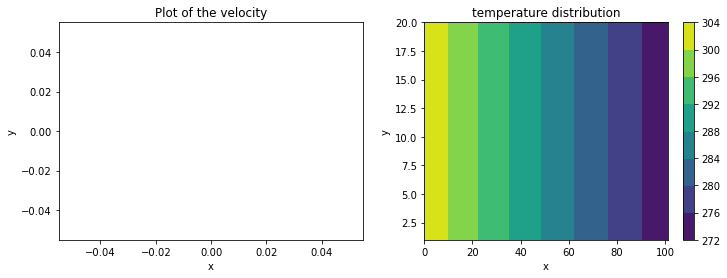

In [46]:
#PLOTTING THE RESULTS
#must pay attention that we are using a staggered arrangement
#this means that the arrangement used for the scalar CV is different from the one used for the velocity

import matplotlib.pyplot as plt

#define the mesh for the scalar CV
X = np.linspace(0, N_x + 1, N_x + 2); #including BC
Y = np.linspace(1, N_y, N_y);

rect_domain = np.zeros((N_y, N_x + 2));

#define the mesh for the velocity
u_coor = np.linspace(0, N_x, N_x + 1);
v_coor = np.linspace(0, N_y, N_y + 1);

U, V = np.meshgrid(u_coor, v_coor);

U[:, :] = 0;
V[:, :] = 0;
        
#check the notes for the structure

for a in range(0, N_x + 1):
    c = a*N_y;
    for b in range(0, N_y):
        d = c + b;
        U[b + 1, a] = vel_u[0, d];

for a in range(0, N_x):
    c = a*(N_y+1);
    for b in range(0, N_y + 1):
        d = c + b;
        V[b, a + 1] = vel_v[0, d];

#plot the velocity field
fig, axes  = plt.subplots(1, 2, figsize = (12, 4));

gr_vel = axes[0];
gr_temp = axes[1];

gr_vel.streamplot(u_coor, v_coor, U, V, linewidth=1, density=1, arrowstyle='->', arrowsize=1.5);
gr_vel.set_xlabel("x");
gr_vel.set_ylabel("y");
gr_vel.set_title("Plot of the velocity");

total_scalar_domain = np.c_[inlet_BC, scalar_CV];
total_scalar_domain = np.c_[total_scalar_domain, outlet_BC];

rect_domain[:, :] = 0;

for a in range(0, N_x + 2):
    c = a*N_y;
    for b in range(0, N_y):
        d = c + b;
        rect_domain[b, a] = total_scalar_domain[0, d];
        
temp_distr = gr_temp.contourf(X, Y, rect_domain);
plt.colorbar(temp_distr, ax = gr_temp);
gr_temp.set_xlabel("x");
gr_temp.set_ylabel("y");
gr_temp.set_title("temperature distribution")